In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

from sqlalchemy import create_engine

In [5]:
# 데이터 병합 및 year 열 추가 함수 정의의: SQL
def get_data_from_db(query):

    # mysql 접속 정보 정의
    username = "admin"
    password = "admin1234"
    host = "hk-toss-middle-project.cjkcuqkegqpx.eu-north-1.rds.amazonaws.com"
    database_name = "raw_data"

    # 데이터베이스 연결 문자열, connection string
    db_connection_str = f'mysql+pymysql://{username}:{password}@{host}/{database_name}'

    # 데이터 베이스 connector 얻어내기
    db_connection = create_engine(db_connection_str)
    db_connection

    df = pd.read_sql(query, con=db_connection)
    return df

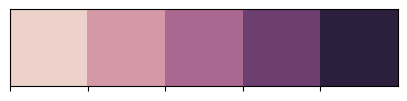

In [6]:
# 시각화 팔레트 설정
default_cube = sns.cubehelix_palette(5)
palette = sns.color_palette(default_cube)
sns.palplot(palette)
sns.set_palette(default_cube)



# 보장 유형

In [7]:
# 3개년 데이터 병합 후 PHI_TYPE, D_YEAR만 불러오기
query = f"""
SELECT 
    D_YEAR,
    PHI_TYPE, 
    SUM(CNT) AS TOTAL_CNT
FROM (
    SELECT 
        2019 AS D_YEAR, 
        PHI4 AS PHI_TYPE, 
        COUNT(PHI4) AS CNT
    FROM 
        raw_a_phi
    GROUP BY 
        PHI4

    UNION ALL

    SELECT 
        2020 AS D_YEAR, 
        PHI4 AS PHI_TYPE, 
        COUNT(PHI4) AS CNT
    FROM 
        raw_b_phi
    GROUP BY 
        PHI4

    UNION ALL

    SELECT 
        2021 AS D_YEAR, 
        PHI4 AS PHI_TYPE, 
        COUNT(PHI4) AS CNT
    FROM 
        raw_c_phi
    GROUP BY 
        PHI4
) AS subquery
GROUP BY 
    D_YEAR,
    PHI_TYPE
ORDER BY TOTAL_CNT DESC;"""
phi_type = get_data_from_db(query)
phi_type.head()

,D_YEAR,PHI_TYPE,TOTAL_CNT
0,2021,"1,2,3",4879.0
1,2020,"1,2,3",4705.0
2,2019,"1,2,3",4433.0
3,2020,2,3345.0
4,2021,2,3314.0


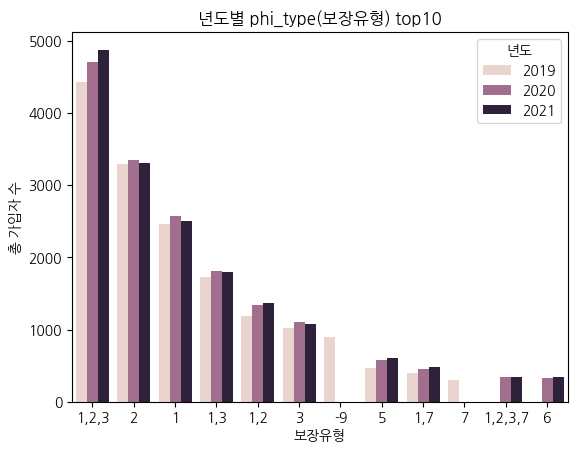

In [8]:
# 시각화

# 년도 별 top10
# 년도 별 top 10 뽑아보기
phi_type_year_sort = phi_type.sort_values(by=["D_YEAR","TOTAL_CNT"], ascending=[True, False]).groupby("D_YEAR").head(10)

# bar chart
import seaborn as sns

sns.barplot(
    data = phi_type_year_sort,
    x = "PHI_TYPE",
    y = "TOTAL_CNT",
    hue="D_YEAR"
)
plt.title("년도별 phi_type(보장유형) top10")
plt.xlabel("보장유형")
plt.ylabel("총 가입자 수")
plt.legend(title="년도")
plt.tight_layout
plt.show()

# 월 납입 보험료

In [9]:
query = f"""
SELECT PHI6 AS PREMIUM, 2019 AS D_YEAR
FROM raw_a_phi
WHERE PHI6 != -9
UNION ALL
SELECT PHI6 AS PREMIUM, 2020 AS D_YEAR
FROM raw_b_phi
WHERE PHI6 != -9
UNION ALL
SELECT PHI6 AS PREMIUM, 2021 AS D_YEAR
FROM raw_c_phi
WHERE PHI6 != -9
"""
phi_premium = get_data_from_db(query)
phi_premium.head()

,PREMIUM,D_YEAR
0,120000.0,2019
1,118000.0,2019
2,48710.0,2019
3,62800.0,2019
4,201717.0,2019


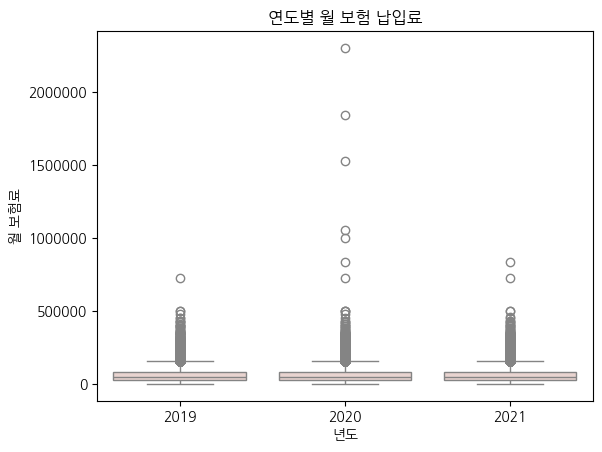

In [ ]:
# boxplot
sns.boxplot(
    data = phi_premium,
    x = "D_YEAR",
    y = "PREMIUM",
)
# y축 tick label을 실수 형식으로 변경
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel("월 보험료")
plt.xlabel("년도")
plt.title("연도별 월 보험 납입료")
plt.show()


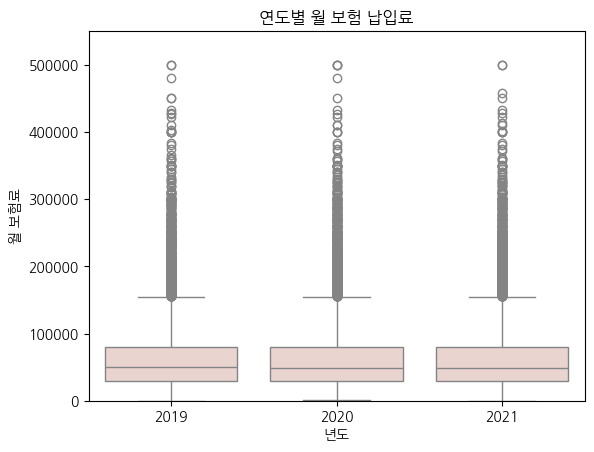

In [11]:
# boxplot
sns.boxplot(
    data = phi_premium,
    x = "D_YEAR",
    y = "PREMIUM",
)
# y축 tick label을 실수 형식으로 변경
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel("월 보험료")
plt.xlabel("년도")
plt.title("연도별 월 보험 납입료")
plt.ylim(0,550000)
plt.show()

# 보험금 청구 여부

In [12]:
query = f"""
SELECT D_YEAR, CLAIM, SUM(CNT) as COUNT
FROM(
SELECT 2019 AS D_YEAR, PHR1 AS CLAIM, COUNT(PHR1) AS CNT
FROM raw_a_phi
GROUP BY PHR1
UNION ALL
SELECT 2020 AS D_YEAR, PHR1 AS CLAIM, COUNT(PHR1) AS CNT
FROM raw_b_phi
GROUP BY PHR1
UNION ALL
SELECT 2021 AS D_YEAR, PHR1 AS CLAIM, COUNT(PHR1) AS CNT
FROM raw_c_phi
GROUP BY PHR1
) AS subquery
GROUP BY D_YEAR, CLAIM
"""
phi_claim = get_data_from_db(query)
phi_claim

,D_YEAR,CLAIM,COUNT
0,2019,1.0,1278.0
1,2019,2.0,19910.0
2,2019,-9.0,350.0
3,2020,1.0,1899.0
4,2020,2.0,19360.0
5,2020,-9.0,86.0
6,2021,2.0,19410.0
7,2021,1.0,1956.0
8,2021,-9.0,26.0


In [13]:
# 범주 값 변경
phi_claim.loc[phi_claim["CLAIM"]==-9, "CLAIM"] = "모름/무응답"
phi_claim.loc[phi_claim["CLAIM"]==1, "CLAIM"] = "예"
phi_claim.loc[phi_claim["CLAIM"]==2, "CLAIM"] = "아니오"

C:\Users\user\AppData\Local\Temp\ipykernel_14800\1788844088.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '모름/무응답' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  phi_claim.loc[phi_claim["CLAIM"]==-9, "CLAIM"] = "모름/무응답"


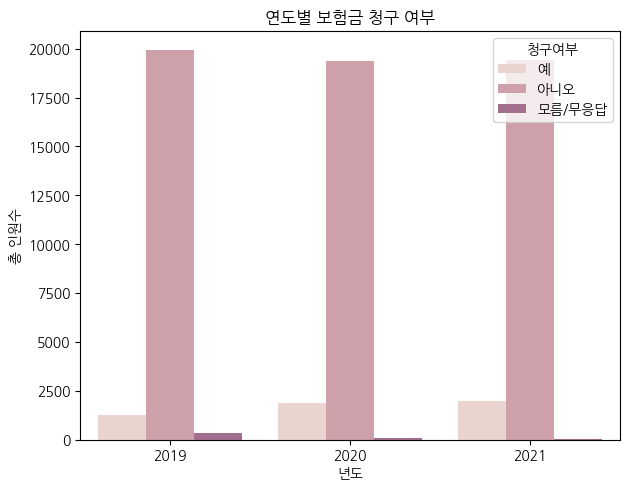

In [14]:
# barplot
sns.barplot(
    data = phi_claim,
    x = "D_YEAR",
    y = "COUNT",
    hue = "CLAIM"
)
plt.tight_layout()
plt.legend(title="청구여부")
plt.title("연도별 보험금 청구 여부")
plt.xlabel("년도")
plt.ylabel("총 인원수")
plt.show()

# 보험금 수령액

In [15]:
query = f"""
SELECT PHR3 AS BENEFIT, 2019 AS D_YEAR
FROM raw_a_phi
WHERE PHR3 is not null AND PHR3 != -9
UNION ALL
SELECT PHR3 AS BENEFIT, 2020 AS D_YEAR
FROM raw_b_phi
WHERE PHR3 is not null AND PHR3 != -9
UNION ALL
SELECT PHR3 AS BENEFIT, 2021 AS D_YEAR
FROM raw_c_phi
WHERE PHR3 is not null AND PHR3 != -9
"""
phi_benefit = get_data_from_db(query)

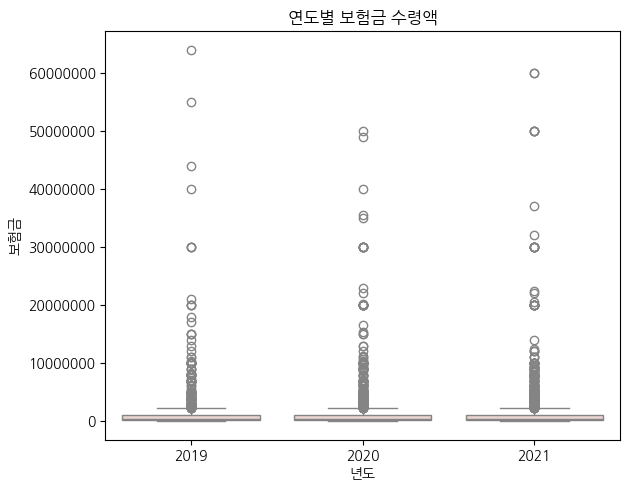

In [16]:
# boxplot
sns.boxplot(
    data = phi_benefit,
    x = "D_YEAR",
    y = "BENEFIT"
)
# y축 tick label을 실수 형식으로 변경
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel("보험금")
plt.xlabel("년도")
plt.tight_layout()
plt.title("연도별 보험금 수령액")
plt.show()

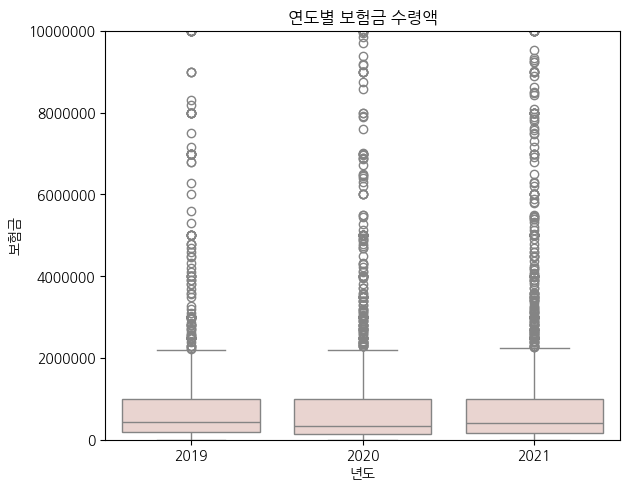

In [17]:
# boxplot
sns.boxplot(
    data = phi_benefit,
    x = "D_YEAR",
    y = "BENEFIT"
)
# y축 tick label을 실수 형식으로 변경
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel("보험금")
plt.xlabel("년도")
plt.tight_layout()
plt.title("연도별 보험금 수령액")
plt.ylim(0,10000000)
plt.show()

# 보험금 수령 여부 별 월 보험료

In [18]:
query = f"""
SELECT PHI6 AS PREMIUM, 2019 AS D_YEAR, PHR2 AS BENEFIT_YN
FROM raw_a_phi
WHERE PHI6 != -9 AND PHI6 is not null AND PHR2 is not null 
UNION ALL
SELECT PHI6 AS PREMIUM, 2020 AS D_YEAR, PHR2 AS BENEFIT_YN
FROM raw_b_phi
WHERE PHI6 != -9 AND PHI6 is not null AND PHR2 is not null 
UNION ALL
SELECT PHI6 AS PREMIUM, 2021 AS D_YEAR, PHR2 AS BENEFIT_YN
FROM raw_c_phi
WHERE PHI6 != -9 AND PHI6 is not null AND PHR2 is not null
"""
phi_benefit_yn_premium = get_data_from_db(query)

In [19]:
phi_benefit_yn_premium.groupby("BENEFIT_YN")["PREMIUM"].mean()

BENEFIT_YN
1.0    74459.237659
2.0    66934.907407
3.0    70411.888889
Name: PREMIUM, dtype: float64

In [20]:
# 범주 값 변경
phi_benefit_yn_premium.loc[phi_benefit_yn_premium["BENEFIT_YN"]==1, "BENEFIT_YN"] = "예"
phi_benefit_yn_premium.loc[phi_benefit_yn_premium["BENEFIT_YN"]==2, "BENEFIT_YN"] = "아니오"
phi_benefit_yn_premium.loc[phi_benefit_yn_premium["BENEFIT_YN"]==3, "BENEFIT_YN"] = "청구진행중"

C:\Users\user\AppData\Local\Temp\ipykernel_14800\135648012.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '예' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  phi_benefit_yn_premium.loc[phi_benefit_yn_premium["BENEFIT_YN"]==1, "BENEFIT_YN"] = "예"


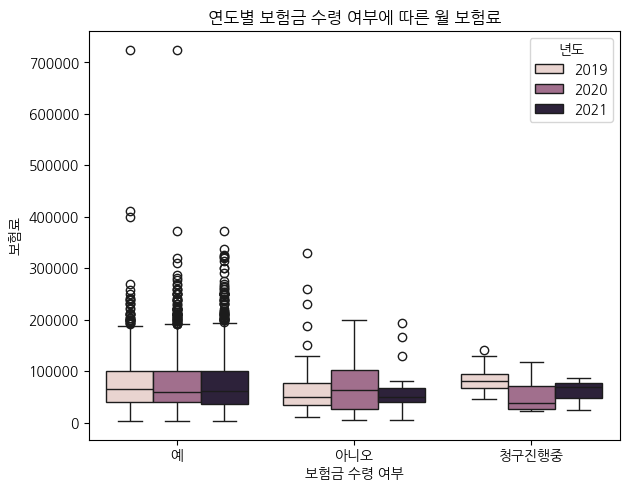

In [23]:
# boxplot
sns.boxplot(
    data = phi_benefit_yn_premium,
    x = "BENEFIT_YN",
    y = "PREMIUM",
    hue = "D_YEAR"
)
plt.tight_layout()
plt.legend(title="년도")
plt.ylabel("보험료")
plt.xlabel("보험금 수령 여부")
plt.title("연도별 보험금 수령 여부에 따른 월 보험료")
plt.show()


# 성별별 보험금, 보험료

In [24]:
query = """ 
SELECT PHI_PID1 AS PIDWON, PHR3 AS BENEFIT, PHI6 AS PREMIUM, 2019 AS D_YEAR
FROM raw_a_phi
WHERE 
    PHR3 != -9 AND PHR3 IS NOT NULL AND
    PHI6 != -9 AND PHI6 IS NOT NULL
UNION ALL
SELECT PHI_PID1 AS PIDWON, PHR3 AS BENEFIT, PHI6 AS PREMIUM, 2020 AS D_YEAR
FROM raw_b_phi
WHERE 
    PHR3 != -9 AND PHI3 IS NOT NULL AND
    PHI6 != -9 AND PHI6 IS NOT NULL
UNION ALL
SELECT PHI_PID1 AS PIDWON, PHR3 AS BENEFIT, PHI6 AS PREMIUM, 2021 AS D_YEAR
FROM raw_c_phi
WHERE 
    PHR3 != -9 AND PHI3 IS NOT NULL AND
    PHI6 != -9 AND PHI6 IS NOT NULL;
"""
phi = get_data_from_db(query)

In [25]:
query = """ 
SELECT PIDWON, SEX, 2019 AS D_YEAR FROM raw_a_ind
UNION ALL
SELECT PIDWON, SEX, 2020 AS D_YEAR FROM raw_b_ind
UNION ALL
SELECT PIDWON, SEX, 2021 AS D_YEAR FROM raw_c_ind
"""

ind = get_data_from_db(query)

In [28]:
df = pd.merge(phi, ind, on=["PIDWON", "D_YEAR"])

In [33]:
df.loc[df["SEX"]==1, "SEX"] = '남'
df.loc[df["SEX"]==2, 'SEX'] = '여'

In [34]:
df

,PIDWON,BENEFIT,PREMIUM,D_YEAR,SEX
0,11200301.0,60000.0,120000.0,2019,남
1,11203301.0,120000.0,87000.0,2019,남
2,11205801.0,1000000.0,60770.0,2019,여
3,11206402.0,3800000.0,75000.0,2019,여
4,11208002.0,600000.0,30000.0,2019,여
...,...,...,...,...,...
4783,30007001.0,545760.0,121260.0,2021,남
4784,30007002.0,1730000.0,144168.0,2021,여
4785,30008104.0,52600.0,39000.0,2021,여
4786,30008504.0,134379.0,109058.0,2021,여


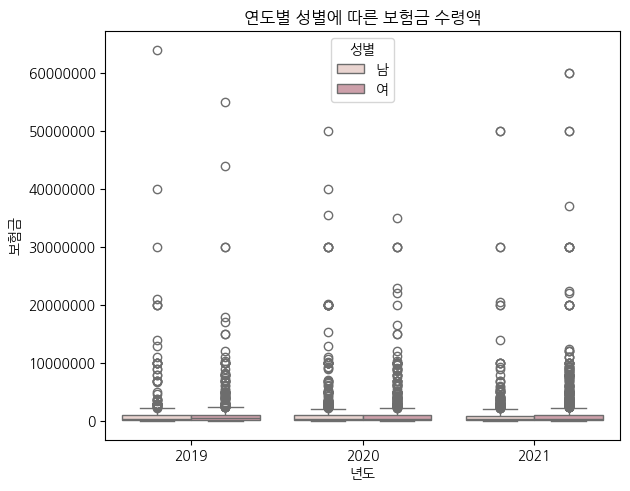

In [39]:
# 성별 별 보험금

# boxplot
sns.boxplot(
    data = df,
    x = "D_YEAR",
    y = "BENEFIT",
    hue = "SEX"
)
# y축 tick label을 실수 형식으로 변경
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel("보험금")
plt.xlabel("년도")
plt.legend(title = "성별")
plt.tight_layout()
plt.title("연도별 성별에 따른 보험금 수령액")
plt.show()

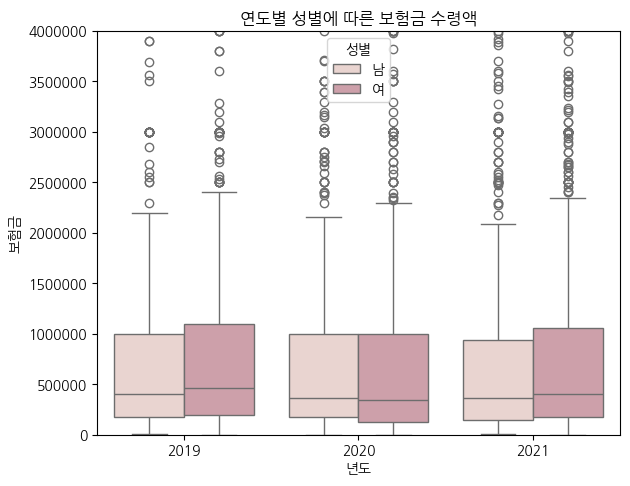

In [40]:
# 성별 별 보험금_ylim

# boxplot
sns.boxplot(
    data = df,
    x = "D_YEAR",
    y = "BENEFIT",
    hue = "SEX"
)
# y축 tick label을 실수 형식으로 변경
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel("보험금")
plt.xlabel("년도")
plt.legend(title = "성별")
plt.ylim(0,4000000)
plt.tight_layout()
plt.title("연도별 성별에 따른 보험금 수령액")
plt.show()

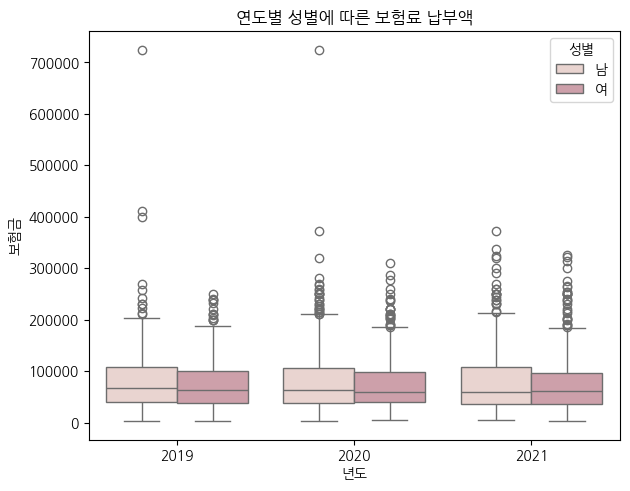

In [ ]:
# 보험료 납부액
# 성별 별 보험금

# boxplot
sns.boxplot(
    data = df,
    x = "D_YEAR",
    y = "PREMIUM",
    hue = "SEX"
)
# y축 tick label을 실수 형식으로 변경
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel("보험금")
plt.xlabel("년도")
plt.legend(title = "성별")
plt.tight_layout()
plt.title("연도별 성별에 따른 보험료 납입액")
plt.show()

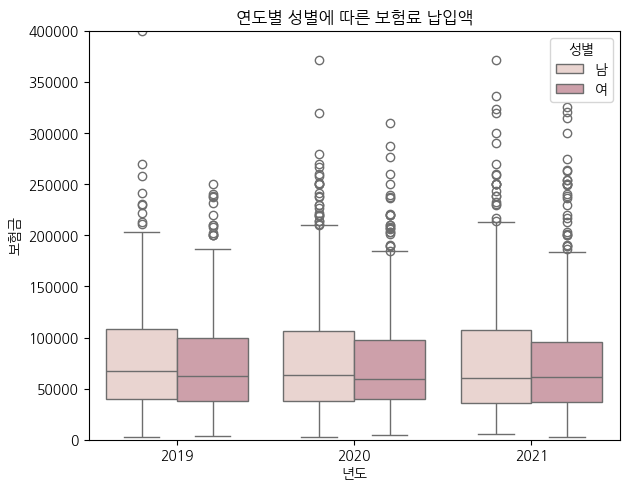

In [43]:
# 보험료 납부액_ylim
# 성별 별 보험금

# boxplot
sns.boxplot(
    data = df,
    x = "D_YEAR",
    y = "PREMIUM",
    hue = "SEX"
)
# y축 tick label을 실수 형식으로 변경
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel("보험금")
plt.xlabel("년도")
plt.legend(title = "성별")
plt.tight_layout()
plt.ylim(0,400000)
plt.title("연도별 성별에 따른 보험료 납입액")
plt.show()

# 주질환 별 의료비, 보험료, 보험금

In [45]:
# 데이터 병합 및 year 열 추가 함수 정의의: SQL
def get_data_from_db(query):

    # mysql 접속 정보 정의
    username = "sumin"
    password = "1234"
    host = "hk-toss-middle-project.cjkcuqkegqpx.eu-north-1.rds.amazonaws.com"
    database_name = "project_db"

    # 데이터베이스 연결 문자열, connection string
    db_connection_str = f'mysql+pymysql://{username}:{password}@{host}/{database_name}'

    # 데이터 베이스 connector 얻어내기
    db_connection = create_engine(db_connection_str)
    db_connection

    df = pd.read_sql(query, con=db_connection)
    return df

In [46]:
query = """
SELECT PIDWON, PHI_BENEFIT, PHI_PREMIUM, H_OOP, D_YEAR, INMED_CNR, INMED_CVD, INMED_ETC, INMED_HPT, INMED_HTN, INMED_LIV, INMED_LRI, INMED_MSD, INMED_OBG
FROM final_model_data_encoded
"""
df = get_data_from_db(query)

In [47]:
# 지수변환
import numpy as np

df["PHI_BENEFIT"] = np.exp(df["PHI_BENEFIT"])-1
df["PHI_PREMIUM"] = np.exp(df["PHI_PREMIUM"])-1
df["H_OOP"] = np.exp(df["H_OOP"])-1

##################################

# 주질환 melt
# 주질환 컬럼명
inmed_col = ['INMED_CVD','INMED_ETC','INMED_HPT','INMED_HTN','INMED_LIV','INMED_LRI','INMED_MSD','INMED_OBG', "INMED_CNR"]

# 주질환 총합 컬럼 생성
df['INMED'] = df[inmed_col].apply(lambda row: ', '.join([col for col in inmed_col if row[col] == 1]), axis=1)

# 주질환 컬럼 삭제
df.drop(inmed_col, axis=1, inplace=True)

##################################

# 값 별 dictionary 생성

# INMED 조건 리스트
conditions = ["CVD", "ETC", "HPT", "HTN", "LIV", "LRI", "MSD", "OBG", "CNR"]

## benefit ##
# 각 조건에 대해 PHI_BENEFIT 값을 저장할 딕셔너리 초기화
benefit_dict = {cond: [] for cond in conditions}

# 조건별로 리스트에 PHI_BENEFIT 추가
for index, row in df.iterrows():
    for cond in conditions:
        if f"INMED_{cond}" in row['INMED']:
            benefit_dict[cond].append(row['PHI_BENEFIT'])


## premium ##
# 각 조건에 대해 PHI_BENEFIT 값을 저장할 딕셔너리 초기화
premium_dict = {cond: [] for cond in conditions}

# 조건별로 리스트에 PHI_BENEFIT 추가
for index, row in df.iterrows():
    for cond in conditions:
        if f"INMED_{cond}" in row['INMED']:
            premium_dict[cond].append(row['PHI_PREMIUM'])


## h_oop ##
# 각 조건에 대해 PHI_BENEFIT 값을 저장할 딕셔너리 초기화
hoop_dict = {cond: [] for cond in conditions}

# 조건별로 리스트에 PHI_BENEFIT 추가
for index, row in df.iterrows():
    for cond in conditions:
        if f"INMED_{cond}" in row['INMED']:
            hoop_dict[cond].append(row['H_OOP'])

#####################################

# 각 값의 평균값 계산
average_benefits = {key: (sum(values) / len(values) if values else None) for key, values in benefit_dict.items()}
average_premium = {key: (sum(values) / len(values) if values else None) for key, values in premium_dict.items()}
average_hoop = {key: (sum(values) / len(values) if values else None) for key, values in hoop_dict.items()}

#####################################

# 데이터 프레임화
data = {
    "INMED" : conditions,
}
data = pd.DataFrame(data)

# 새로운 BENEFIT 컬럼 추가
def get_benefit(inmed):
    for cond in average_benefits.keys():
        if f"{cond}" in inmed:
            return average_benefits[cond]
    return None

data["BENEFIT"] = data["INMED"].apply(get_benefit)


# 새로운 PREMIUM 컬럼 추가
def get_premium(inmed):
    for cond in average_premium.keys():
        if f"{cond}" in inmed:
            return average_premium[cond]
    return None

data["PREMIUM"] = data["INMED"].apply(get_premium)

# 새로운 H_OOP컬럼 추가
def get_hoop(inmed):
    for cond in average_hoop.keys():
        if f"{cond}" in inmed:
            return average_hoop[cond]
    return None

data["H_OOP"] = data["INMED"].apply(get_hoop)


In [50]:
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

In [51]:
# 폰트 파일 경로 설정 (예: Windows의 경우)
font_path = 'C:/Windows/Fonts/malgun.ttf'  # Malgun Gothic 폰트 경로 (한글 지원)

# FontProperties 객체 생성
font_prop = font_manager.FontProperties(fname=font_path, size=12)

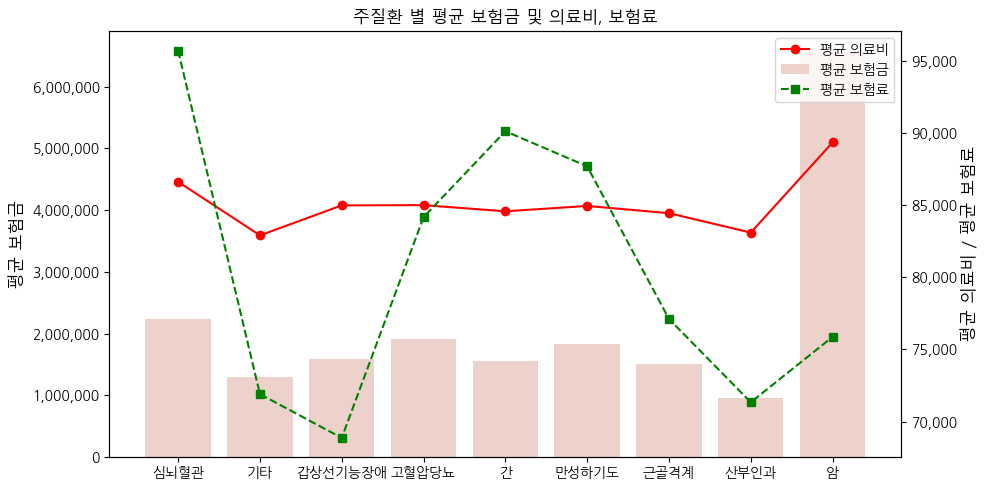

In [52]:
# 시각화
x = data["INMED"]
y_bar = data["BENEFIT"]
y_line2 = data["H_OOP"]
y_line = data["PREMIUM"]

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.bar(x, y_bar, label="평균 보험금")
ax1.set_ylabel("평균 보험금", color="black", fontproperties=font_prop)
ax1.tick_params(axis='y', labelcolor="black")

ax1.plot(x, y_line2, color="red", marker="o", label="평균 의료비")

ax2 = ax1.twinx()

ax2.plot(x, y_line, color="green", marker="s", linestyle="--", label="평균 보험료")

ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x):,}"))
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x):,}"))

ax2.set_ylabel("평균 의료비 / 평균 보험료", color="black", fontproperties=font_prop)
ax2.tick_params(axis='y', labelcolor="black")

plt.title("주질환 별 평균 보험금 및 의료비, 보험료", fontproperties=font_prop)
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")

# x축이름 설정
new_x_labels = ['심뇌혈관', '기타', '갑상선기능장애', '고혈압당뇨', '간', 
                '만성하기도', '근골격계', '산부인과', '암']
ax1.set_xticks(range(len(x)))
ax1.set_xticklabels(new_x_labels)

plt.tight_layout()
plt.show()